# Traffic Sign Recognition with Convolution Neural Network

### Author: Jiqian Dong
### dong282@purdue.edu

In this tutorial, you should be able to see a simple Convolutional Neural Network (CNN) based model implemented with tensorflow [Keras framework](https://keras.io/). The model should be able to recognize the simple traffic signs, which is super essential in building autonomous driving systems. In general, recognizing the traffic signs is not a tough problem with modern computer vision techniques. The main challenge is using less dataset and achieving fast inference for real time implementation.


**Suggestion**: Keras is probably the easiest way of building deep learning models, much more friendly than basic Tensorflow. I would suggest you start from Keras and try to do some implementations by your own. Don't forget to add them into your resume!

In [1]:
import keras as K
import matplotlib.pyplot as plt
import csv
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. First glimps on dataset

In this tutorial, we use an open source dataset named The German Traffic Sign Recognition Benchmark
 :[GTSRB](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads) 
 
__Remark__: Before running the code, first down load the dataset from [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html)

Download and extract the ``GTSRB-Training_fixed.zip`` file, then copy the ``Training`` folder inside into ``./dataset/`` folder.


The dataset contains more than 50,000 images in total and more than 40 classes. 

The following function can be downloaded from the dataset website

In [2]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [3]:
 images, labels = readTrafficSigns('./dataset/Training')

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
len(images),len(labels)

(26640, 26640)

In [6]:
unique_label, counts = np.unique(labels,return_counts=True)
len(unique_label)

43

<Container object of 41 artists>

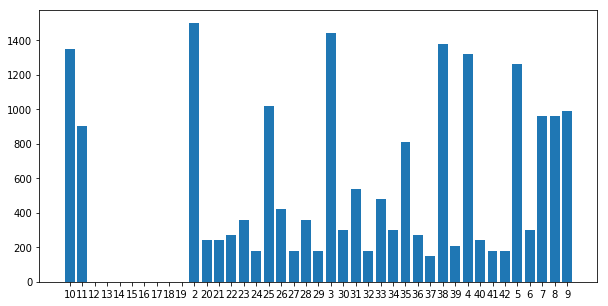

In [7]:
#### Heck !!! 
#### why my matpotlib bar plot can not plot all the bars !!!
#### if you can help me figure out what is wrong, please please email me !!!!
plt.figure(figsize=(10,5))
plt.bar(unique_label[2:],counts[2:])

<Container object of 43 artists>

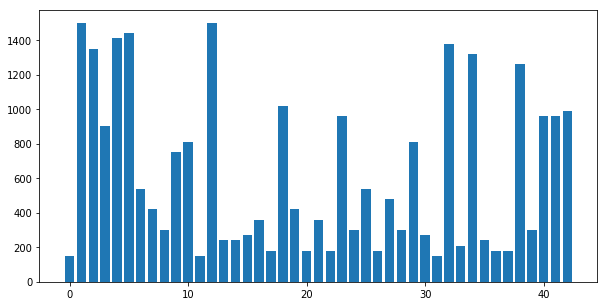

In [8]:
# this works
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(counts)),counts)

**Remark**: 

The dataset is highly imbalanced, some labels have 1500+ images, some only have 200+ images. If this unbalanced image set is directly fed into the model, the model will "pay more attention" on the major classes with large number of training examples. To avoid this bias, we need to first balance the dataset.

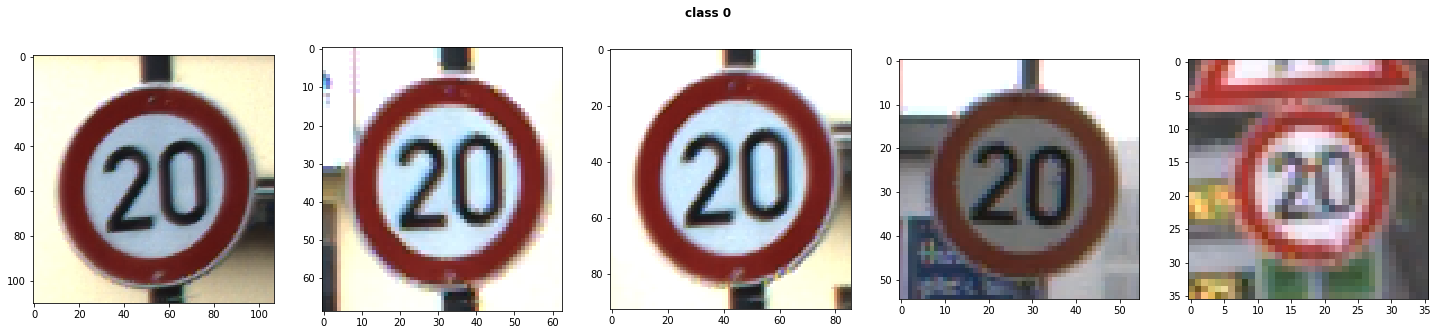

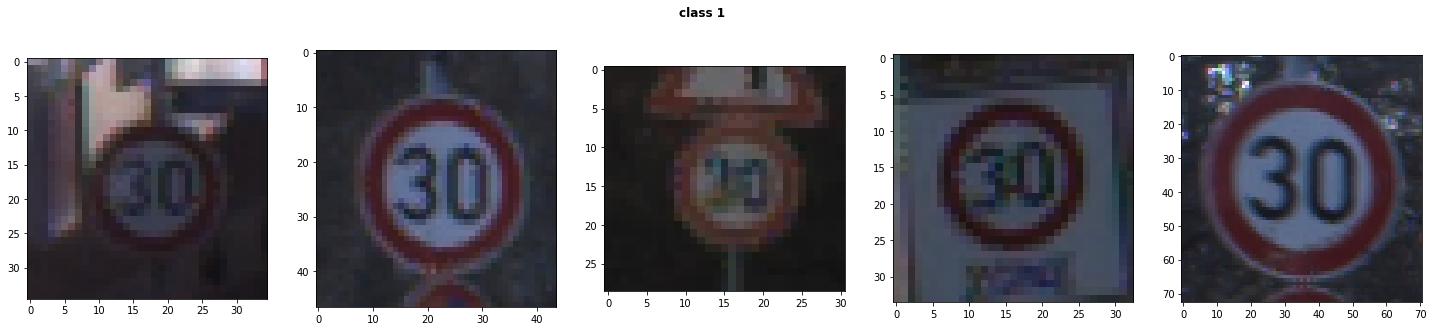

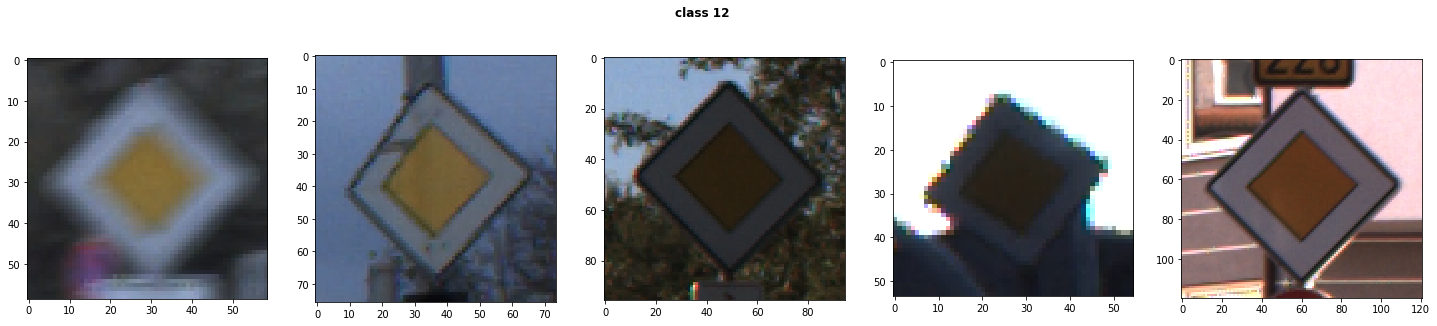

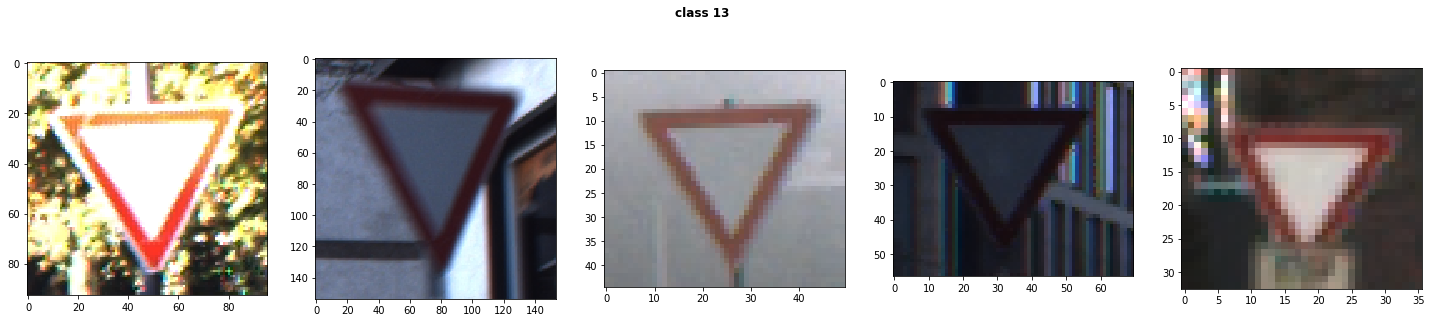

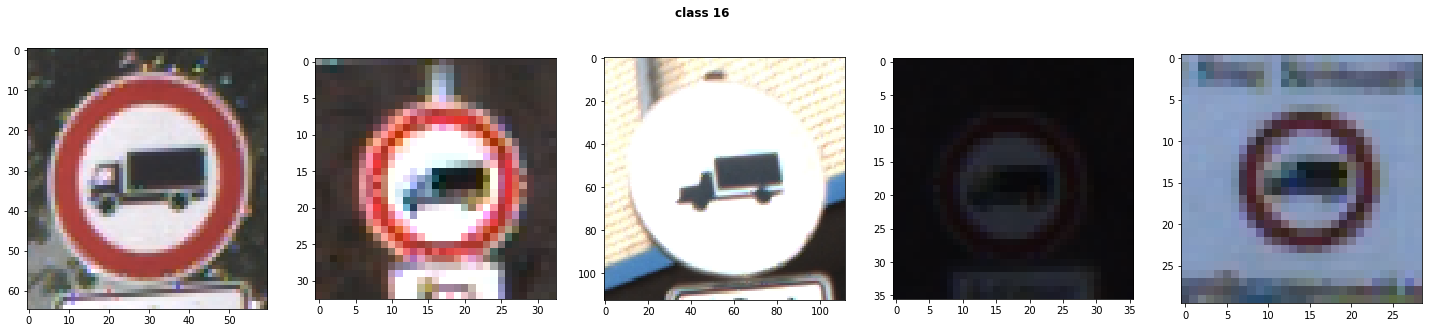

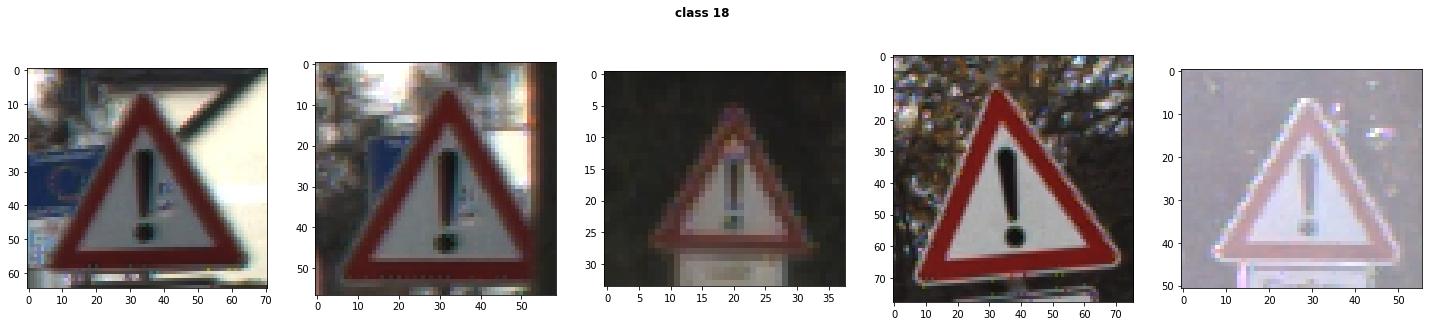

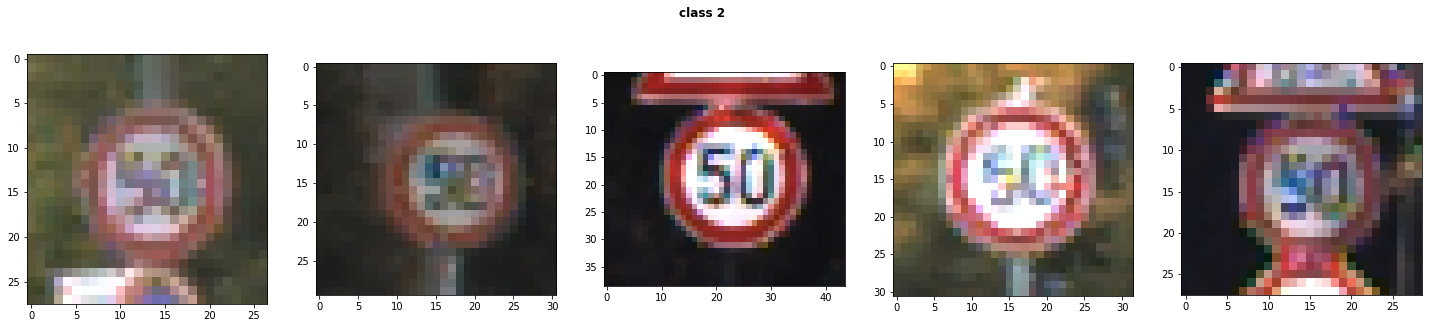

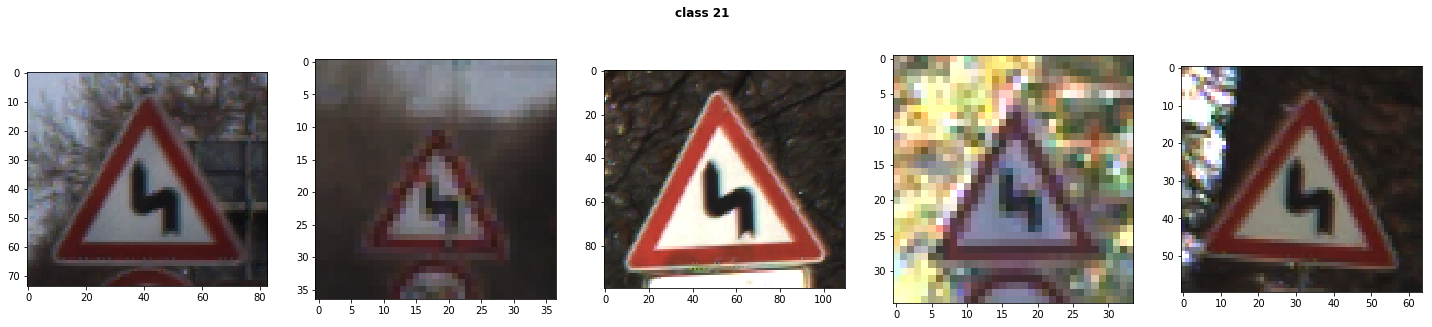

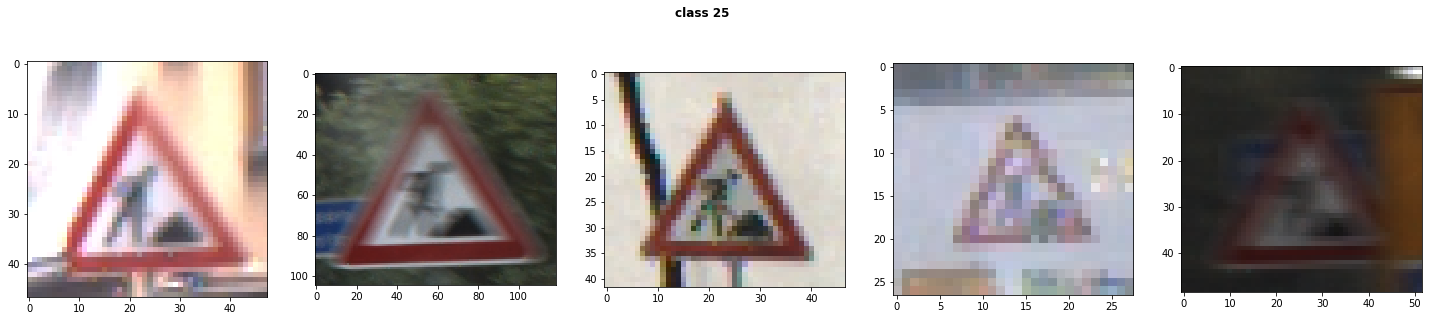

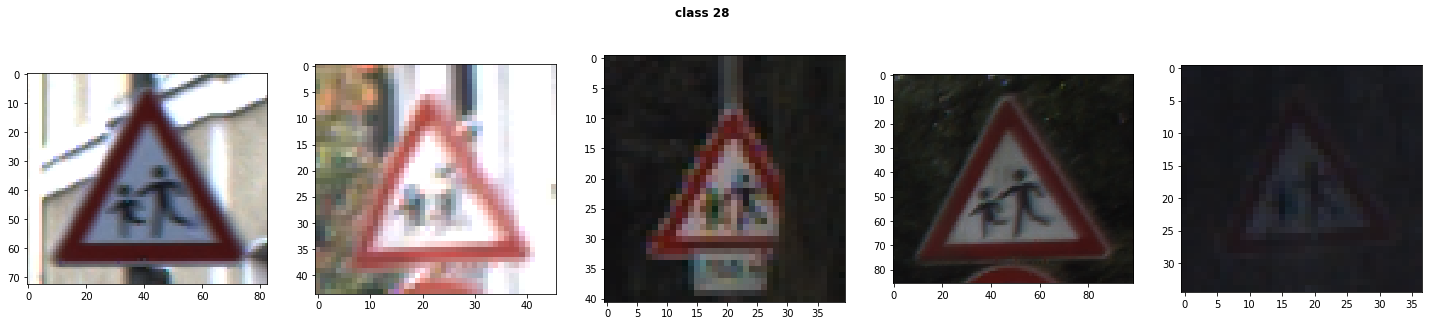

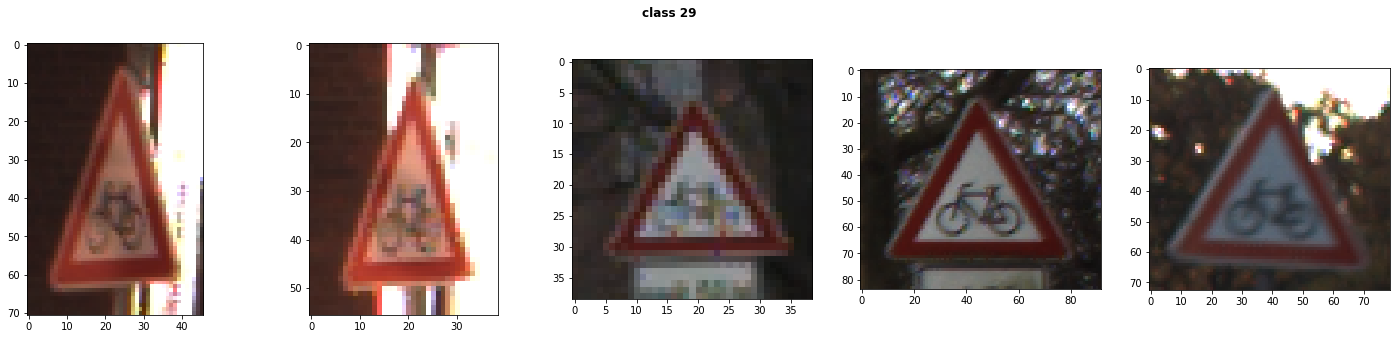

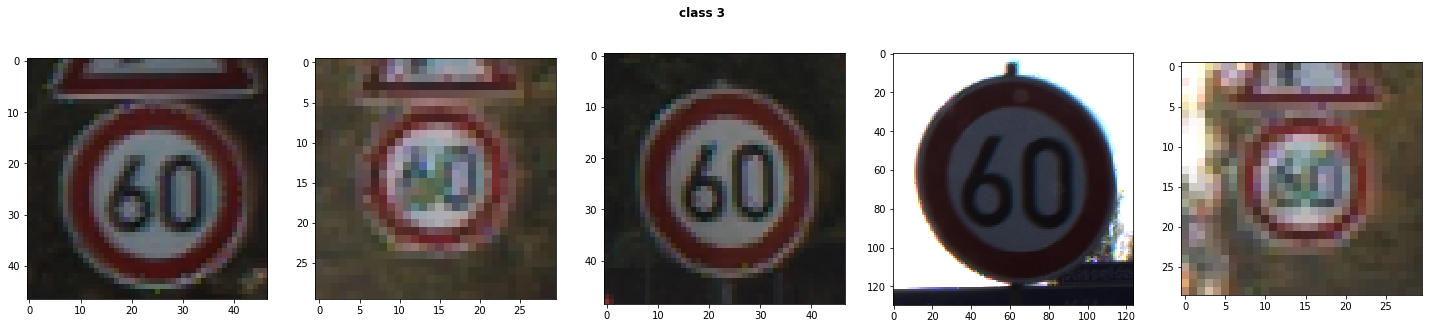

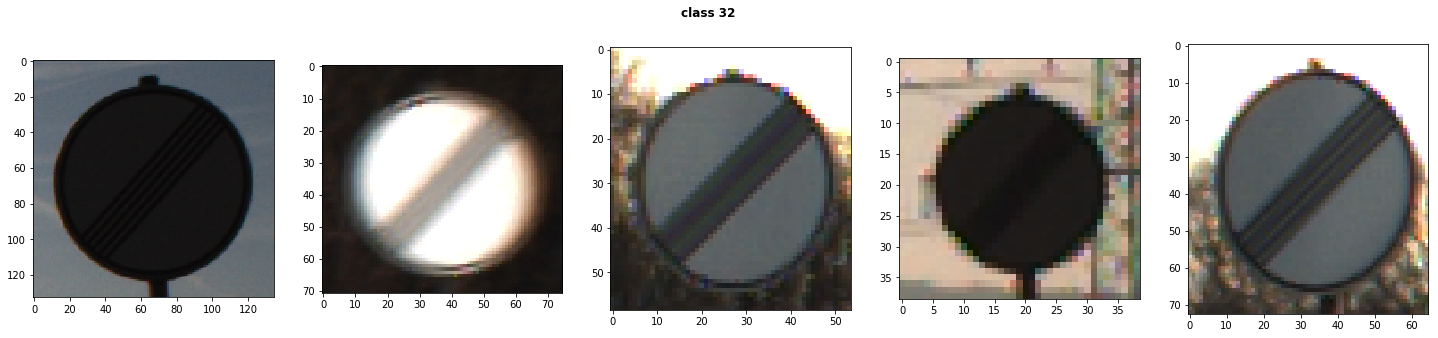

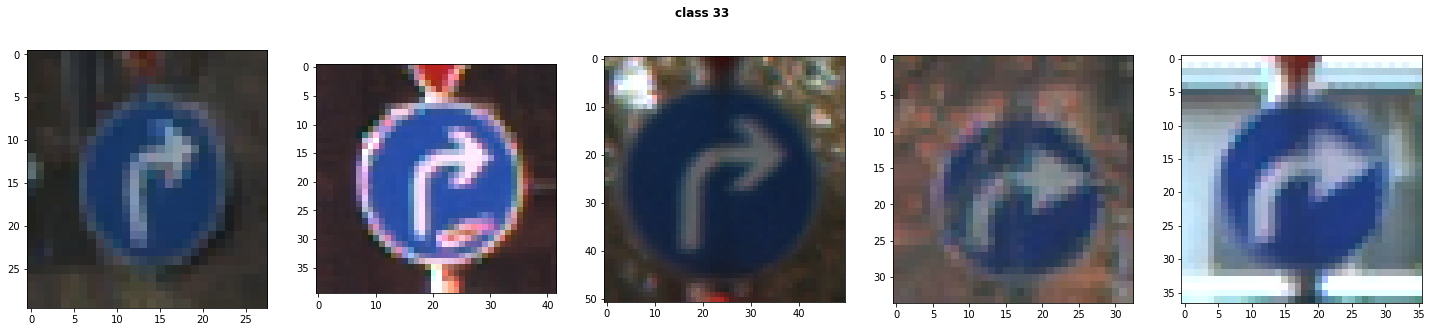

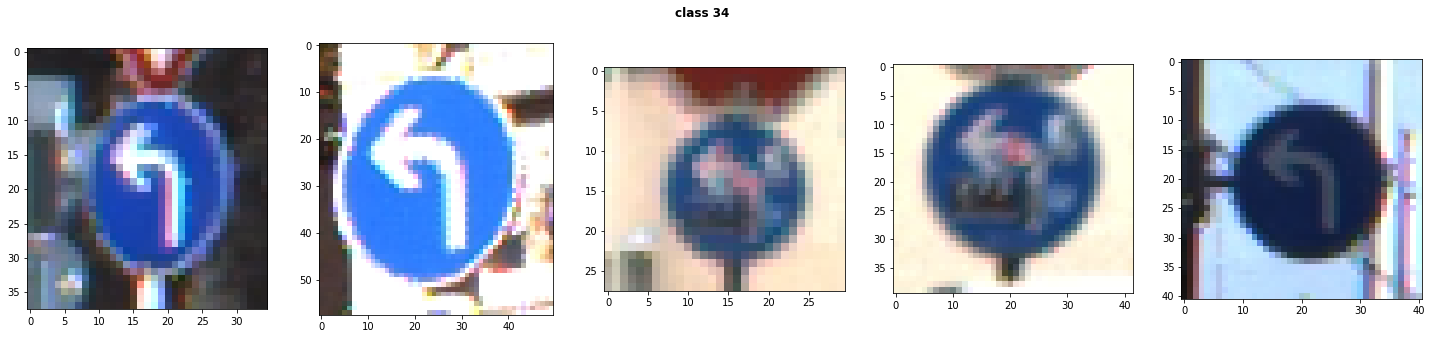

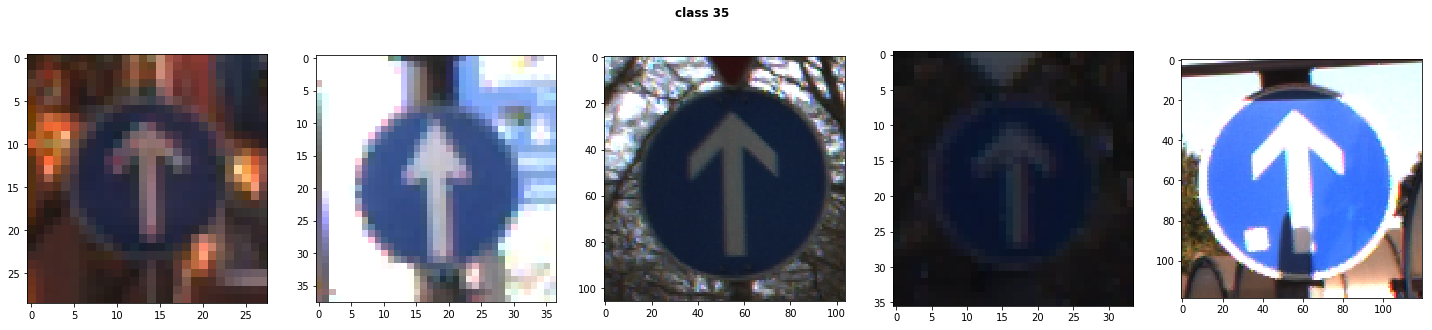

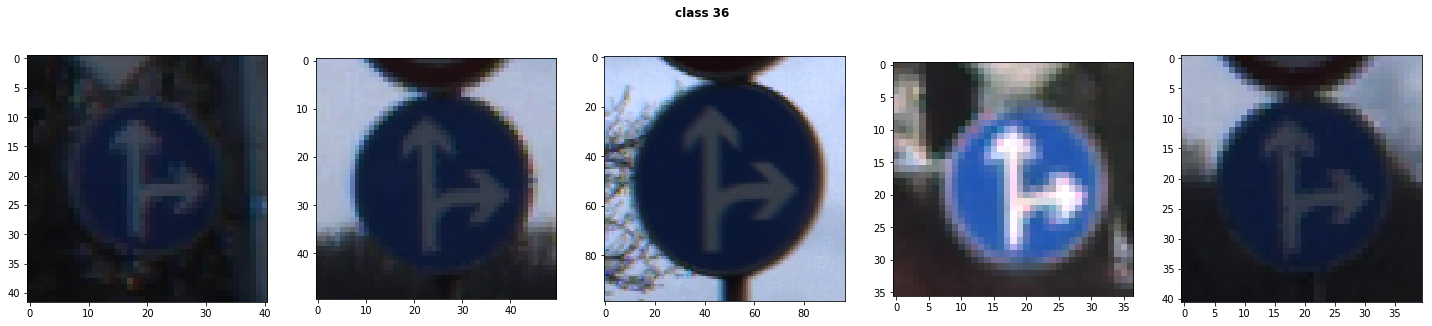

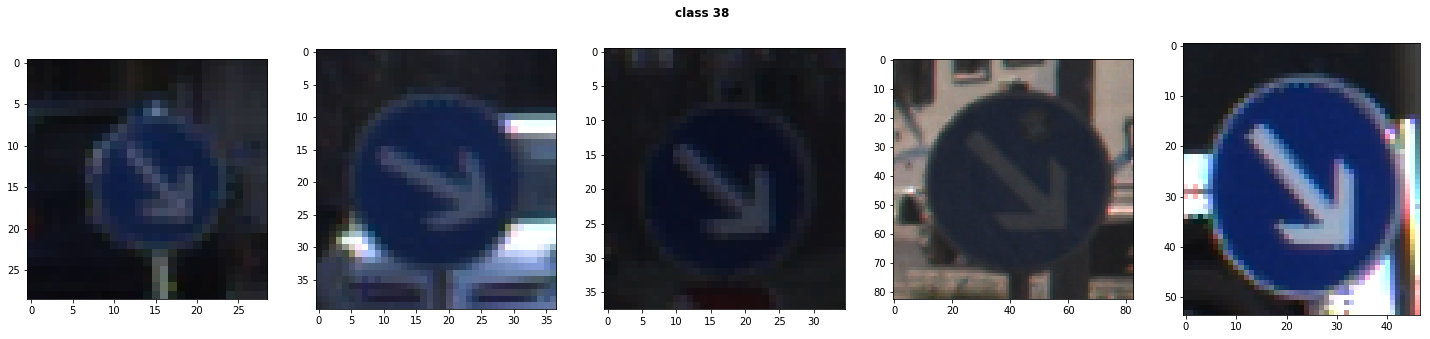

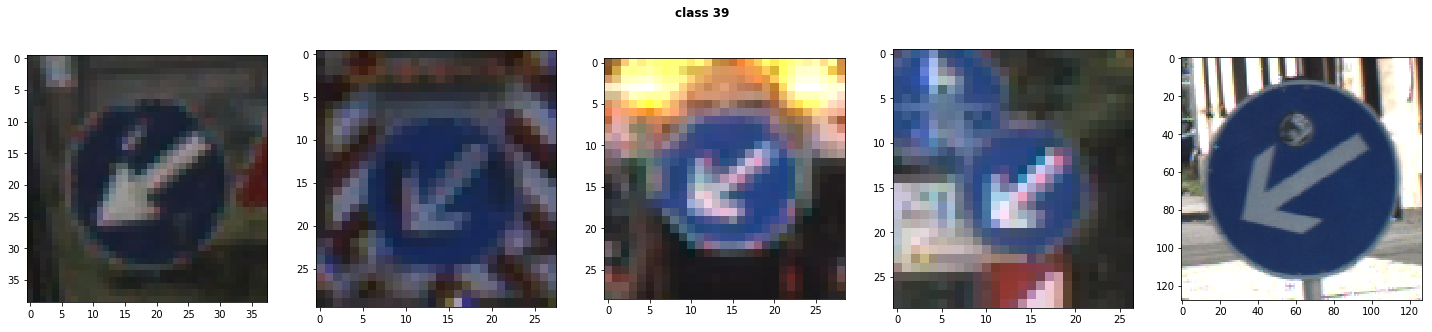

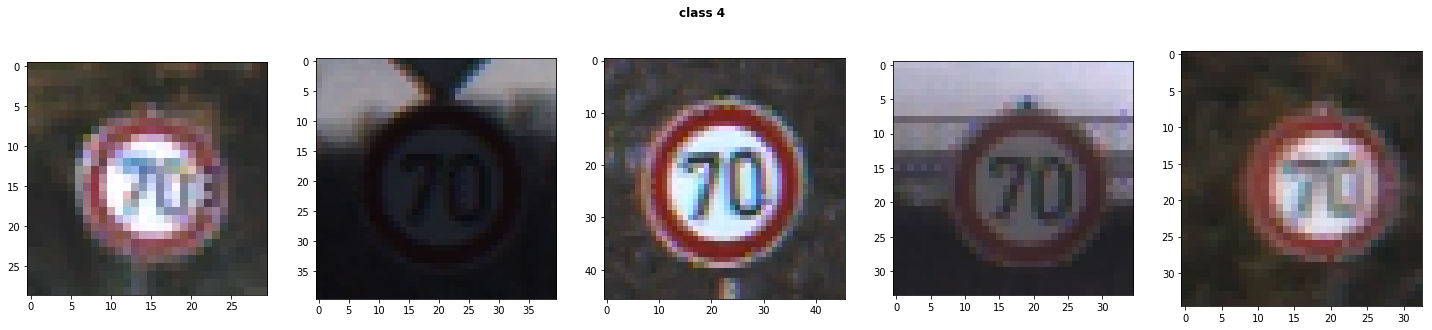

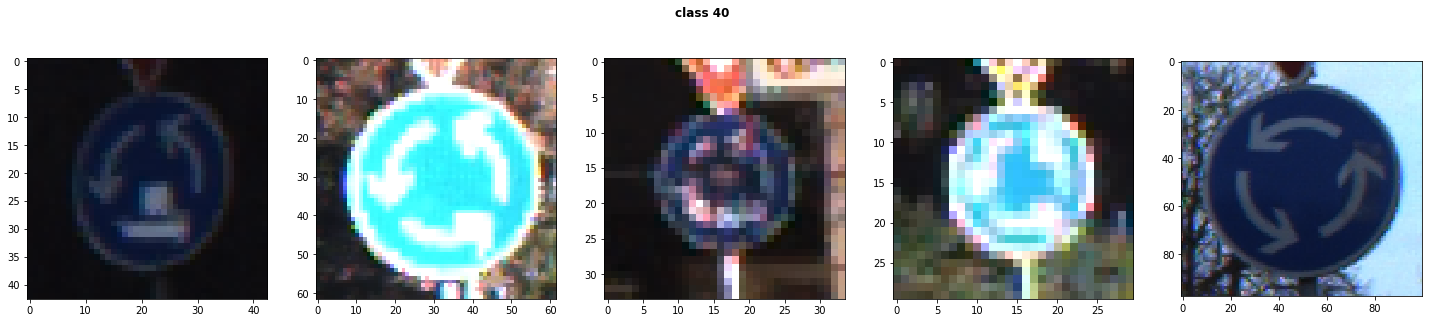

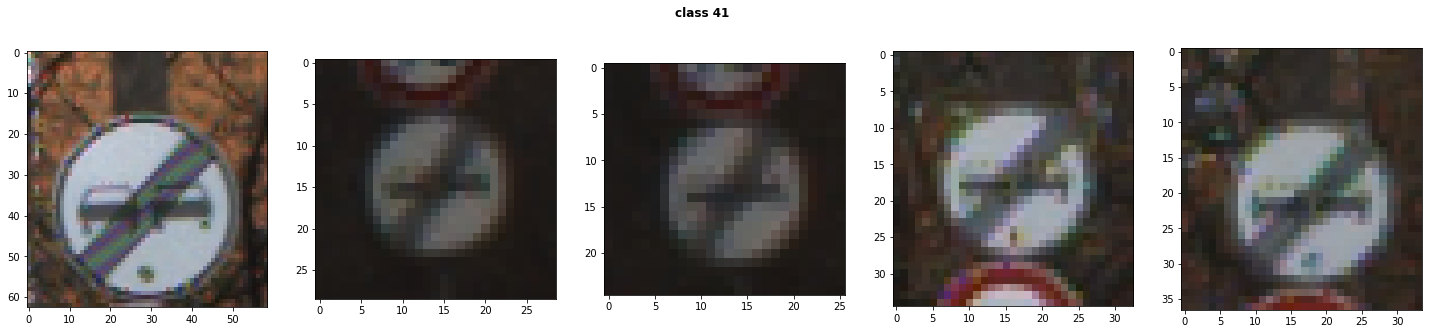

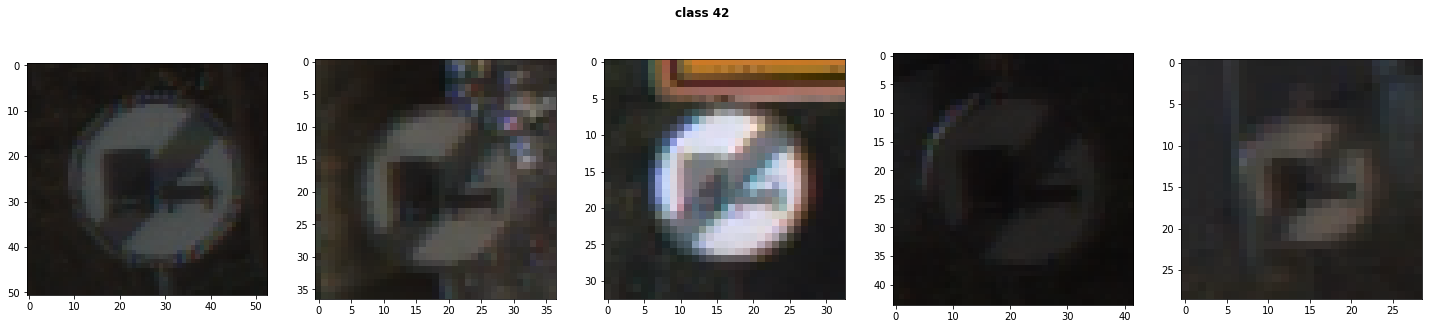

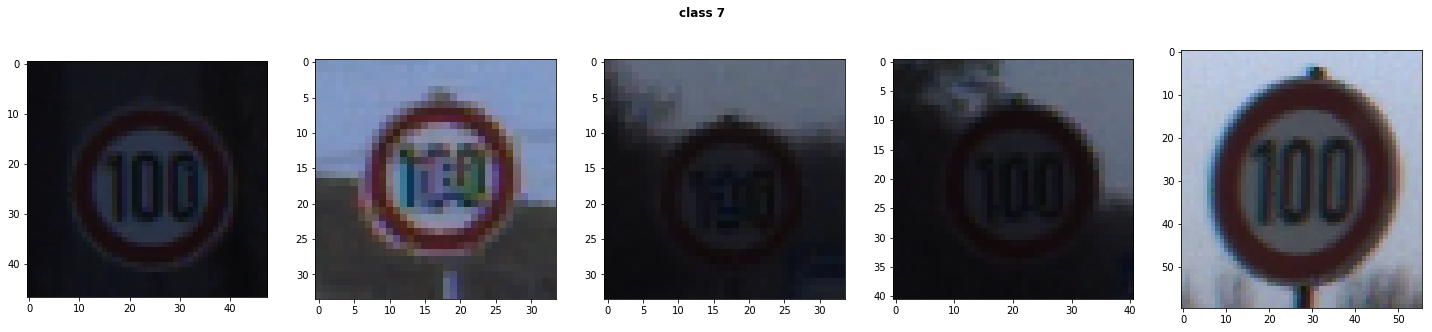

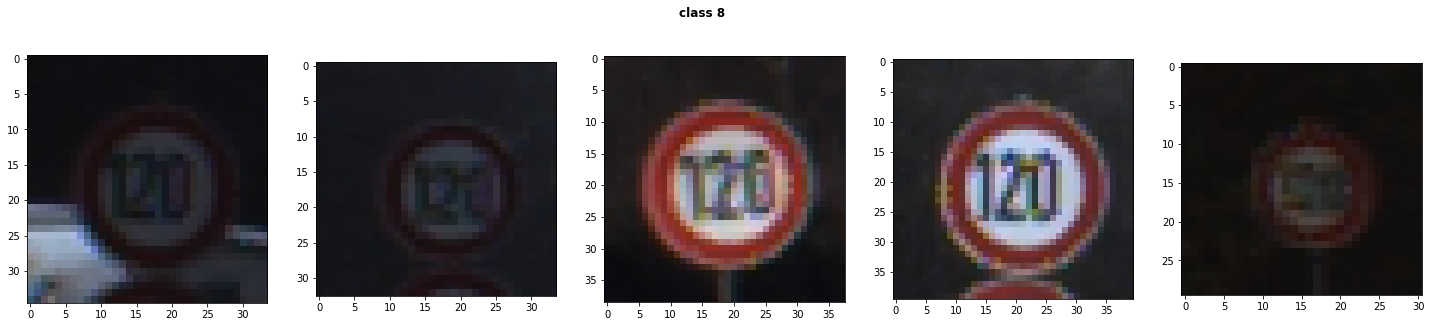

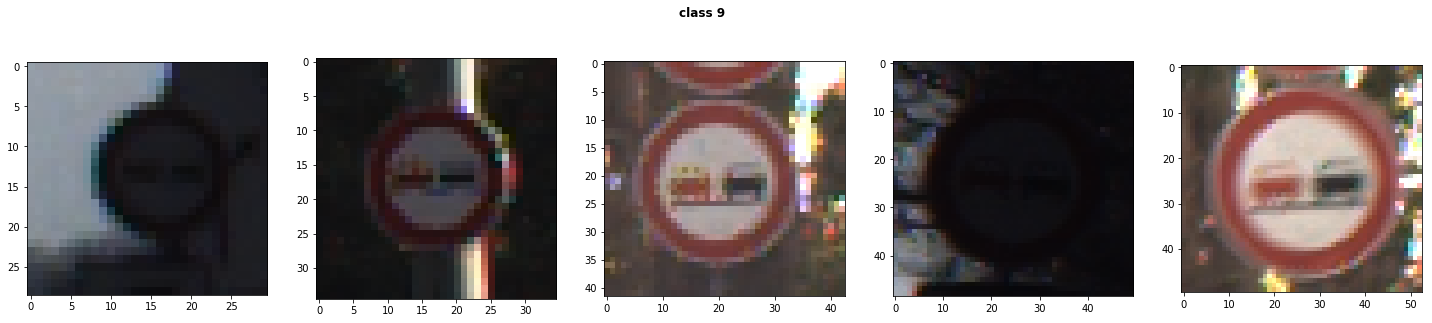

In [9]:
# Random select 5 images from each label class for visualization
n_images_each_class = 5
for lbl in unique_label:
    fig, axes = plt.subplots(1, 5, figsize=(n_images_each_class*5,5))
    inds = np.argwhere(labels==lbl).flatten()
    inds_chose = np.random.choice(inds,size=n_images_each_class)
    for i in range(n_images_each_class):
        axes[i].imshow(images[inds_chose[i]])
    fig.suptitle("class " + lbl, fontsize=12, fontweight='bold')
    plt.show()

## 2.  Image preprocessing

Since the dataset is imbalanced, the size for each image is different, the scale of pixel values for the images is different (some are brighter, some are somber). Also, we sometimes need our model to able to recognize the signs based on their shape instead of color, we can further transfer the images into grayscale.
Before feed the training images in to CNN, propoer preprocessing method should be performed, one typical pipeline is: 

Sample and balance dataset --> resize --> grayscale --> normalization 



In [10]:
import skimage
skimage.__version__

'0.15.0'

In [11]:
from skimage.transform import resize
from skimage.color import rgb2gray

In [12]:
def normalise_images(img):

    std = np.std(img)

    mean = np.mean(img)

    return (img - mean) / std

In [13]:
def create_sample_set(imgs, labels, new_size, num_each_class):

    X_sample = []
    y_sample = []

    unique_label = np.unique(labels)
    for lbl in unique_label:
        inds = np.argwhere(labels==lbl).flatten()
        inds_chose = np.random.choice(inds,size=num_each_class,replace=True) # if replace is false, the size should be smaller than the total number in that class
        
        for i in inds_chose:
            
            ## Preprocessing steps
            img = resize(imgs[i],new_size)
            img = rgb2gray(img)
            img = normalise_images(img)
            
            X_sample.append(img.reshape((32,32,1)))
            y_sample.append(labels[i])
           
    
    return np.array(X_sample), np.array(y_sample)


# Here we choose 200 images per class
X,y = create_sample_set(images, labels, (32,32,3), 200)

In [14]:
X.shape,y.shape

((8600, 32, 32, 1), (8600,))

__Remark__: Since currently, all the y labels are str object, we need to transfer it using one hot encoding for future training. The vector is all zeroes except in the position for the respective category.Thus a '5' will be represented by [0,0,0,0,1,0,0,0,0,0....0] with length 43.

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False) ## be sure to set sparse = False, otherwise keras may have trouble 
encoder.fit(y.reshape(-1,1))

y_labels = encoder.transform(y.reshape(-1,1))

In [40]:
X.shape,y_labels.shape

((8600, 32, 32, 1), (8600, 43))

In [17]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y_labels,test_size=0.3)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6020, 32, 32, 1), (6020, 43), (2580, 32, 32, 1), (2580, 43))

## 3. Build our first classifier

In [19]:

model = K.models.Sequential()
model.add(K.layers.Conv2D(32,kernel_size=(3,3),input_shape=(32,32,1),kernel_initializer='he_normal'))
model.add(K.layers.MaxPooling2D((2,2)))
model.add(K.layers.Conv2D(64,kernel_size=(3,3),input_shape=(32,32,1),kernel_initializer='he_normal'))
model.add(K.layers.MaxPooling2D((2,2)))
model.add(K.layers.Conv2D(128,kernel_size=(3,3),input_shape=(32,32,1),kernel_initializer='he_normal'))
model.add(K.layers.MaxPooling2D((2,2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(128,activation='relu'))
model.add(K.layers.Dense(64,activation='relu'))
model.add(K.layers.Dense(len(unique_label),activation='softmax'))


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
__________

In [21]:
# compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## 4. Train the model

In [22]:
# This will take around 8 minutes to run on CPU. If you have GPU support, it is super fast!
# If you don't want to train on your own, please feel free to comment this line

# Shuffle = True means the dataset is shuffled to mix the images with different class
history = model.fit(X_train,y_train,batch_size=64,epochs=50,shuffle=True,validation_data=(X_test, y_test))

Train on 6020 samples, validate on 2580 samples
Epoch 1/50
6020/6020 [==============================] - 9s - loss: 2.3274 - acc: 0.4085 - val_loss: 1.1038 - val_acc: 0.6783
Epoch 2/50
6020/6020 [==============================] - 9s - loss: 0.6875 - acc: 0.8043 - val_loss: 0.5069 - val_acc: 0.8581
Epoch 3/50
6020/6020 [==============================] - 8s - loss: 0.2844 - acc: 0.9166 - val_loss: 0.2920 - val_acc: 0.9151
Epoch 4/50
6020/6020 [==============================] - 9s - loss: 0.1577 - acc: 0.9551 - val_loss: 0.2652 - val_acc: 0.9256
Epoch 5/50
6020/6020 [==============================] - 8s - loss: 0.0953 - acc: 0.9743 - val_loss: 0.2429 - val_acc: 0.9318
Epoch 6/50
6020/6020 [==============================] - 8s - loss: 0.0778 - acc: 0.9781 - val_loss: 0.2543 - val_acc: 0.9357
Epoch 7/50
6020/6020 [==============================] - 8s - loss: 0.0516 - acc: 0.9849 - val_loss: 0.1993 - val_acc: 0.9554
Epoch 8/50
6020/6020 [==============================] - 8s - loss: 0.0468 - a

In [23]:
# save the model
import os
save_dir = "./results/"
model_name = 'sign_recognition.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./results/sign_recognition.h5 


## 5. Plot the training curve

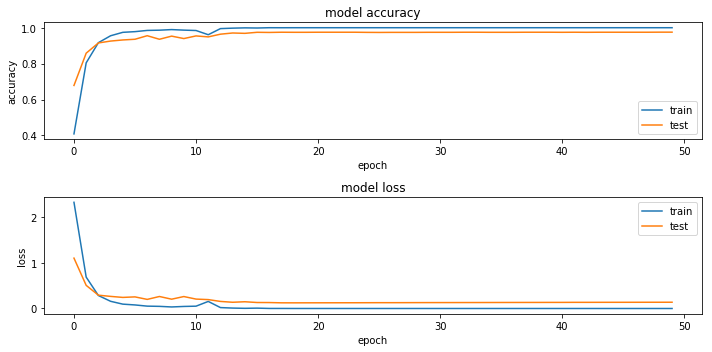

In [26]:
# plotting the metrics
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

## 6. Inference

In [31]:
# load the model and create predictions on the test set
model_dir = "./results/"
model_name = 'sign_recognition.h5'
model_path = os.path.join(model_dir, model_name)
model = K.models.load_model(model_path)
predicted_classes = model.predict_classes(X_test)

2528/2580 [============================>.] - ETA: 0s

In [37]:
num_correct_predict = np.sum(predicted_classes == y_test.argmax(axis=1))
num_wrong_predict = np.sum(predicted_classes != y_test.argmax(axis=1))
print("correct:{}, wrong: {}".format(num_correct_predict,num_wrong_predict))

correct:2516, wrong: 64
